## IGO15488_2
8/27/2024 - Data generated from 14 week KPT mice from Klavdija. CellRanger v6.1.1 rerun by Jason 8/28, analyzed by JC 8/29/2024

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib

from pathlib import Path
import anndata

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/2416973726.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [3]:
#Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [4]:
results_file = 'write/KPT2-IGO15488_2.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_h5('GSE277777_KPT2-filtered_feature_bc_matrix.h5', gex_only=False)

reading KPT2-filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [8]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [9]:
hashadata.var

gene_ids     feature_types genome
BF1596_B0301   BF1596  Antibody Capture       
BD1976_B0302   BD1976  Antibody Capture       
BD1959_B0303   BD1959  Antibody Capture       
BF1595_B0304   BF1595  Antibody Capture       
BF1449_B0305   BF1449  Antibody Capture       
BF1106_B0311   BF1106  Antibody Capture       
BF1588_B0312   BF1588  Antibody Capture       
BD1971_B0313   BD1971  Antibody Capture       
BB1053_B0314   BB1053  Antibody Capture       
BD1446_B0315   BD1446  Antibody Capture

## Preprocessing

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


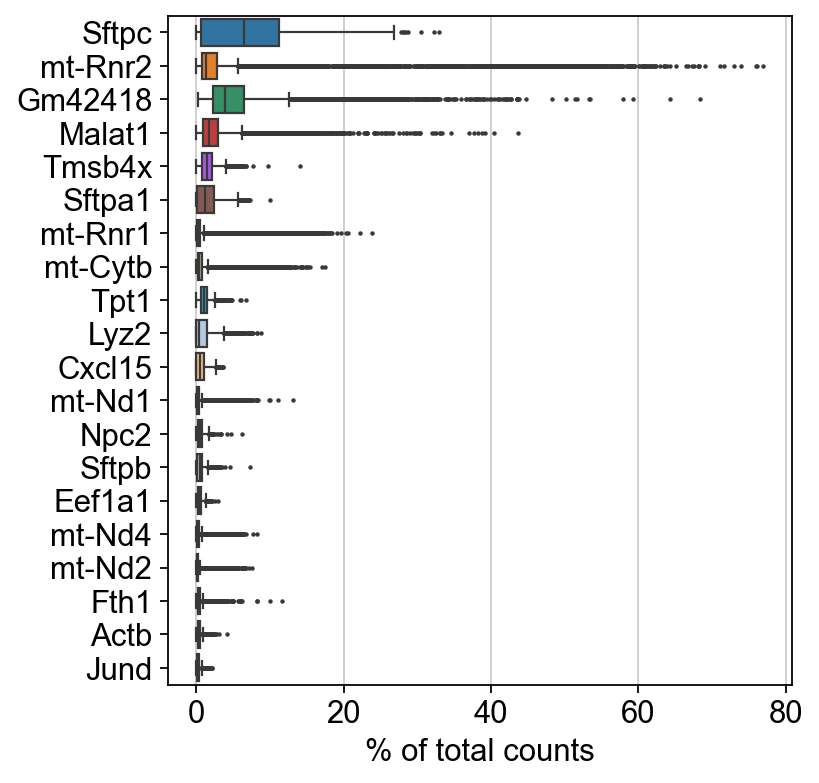

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [11]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)
#sc.pp.filter_genes(adata, min_cells=0.1*len(adata.obs))

filtered out 1328 cells that have less than 1500 counts
filtered out 69 cells that have less than 300 genes expressed
filtered out 30603 genes that are detected in less than 3 cells


In [12]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

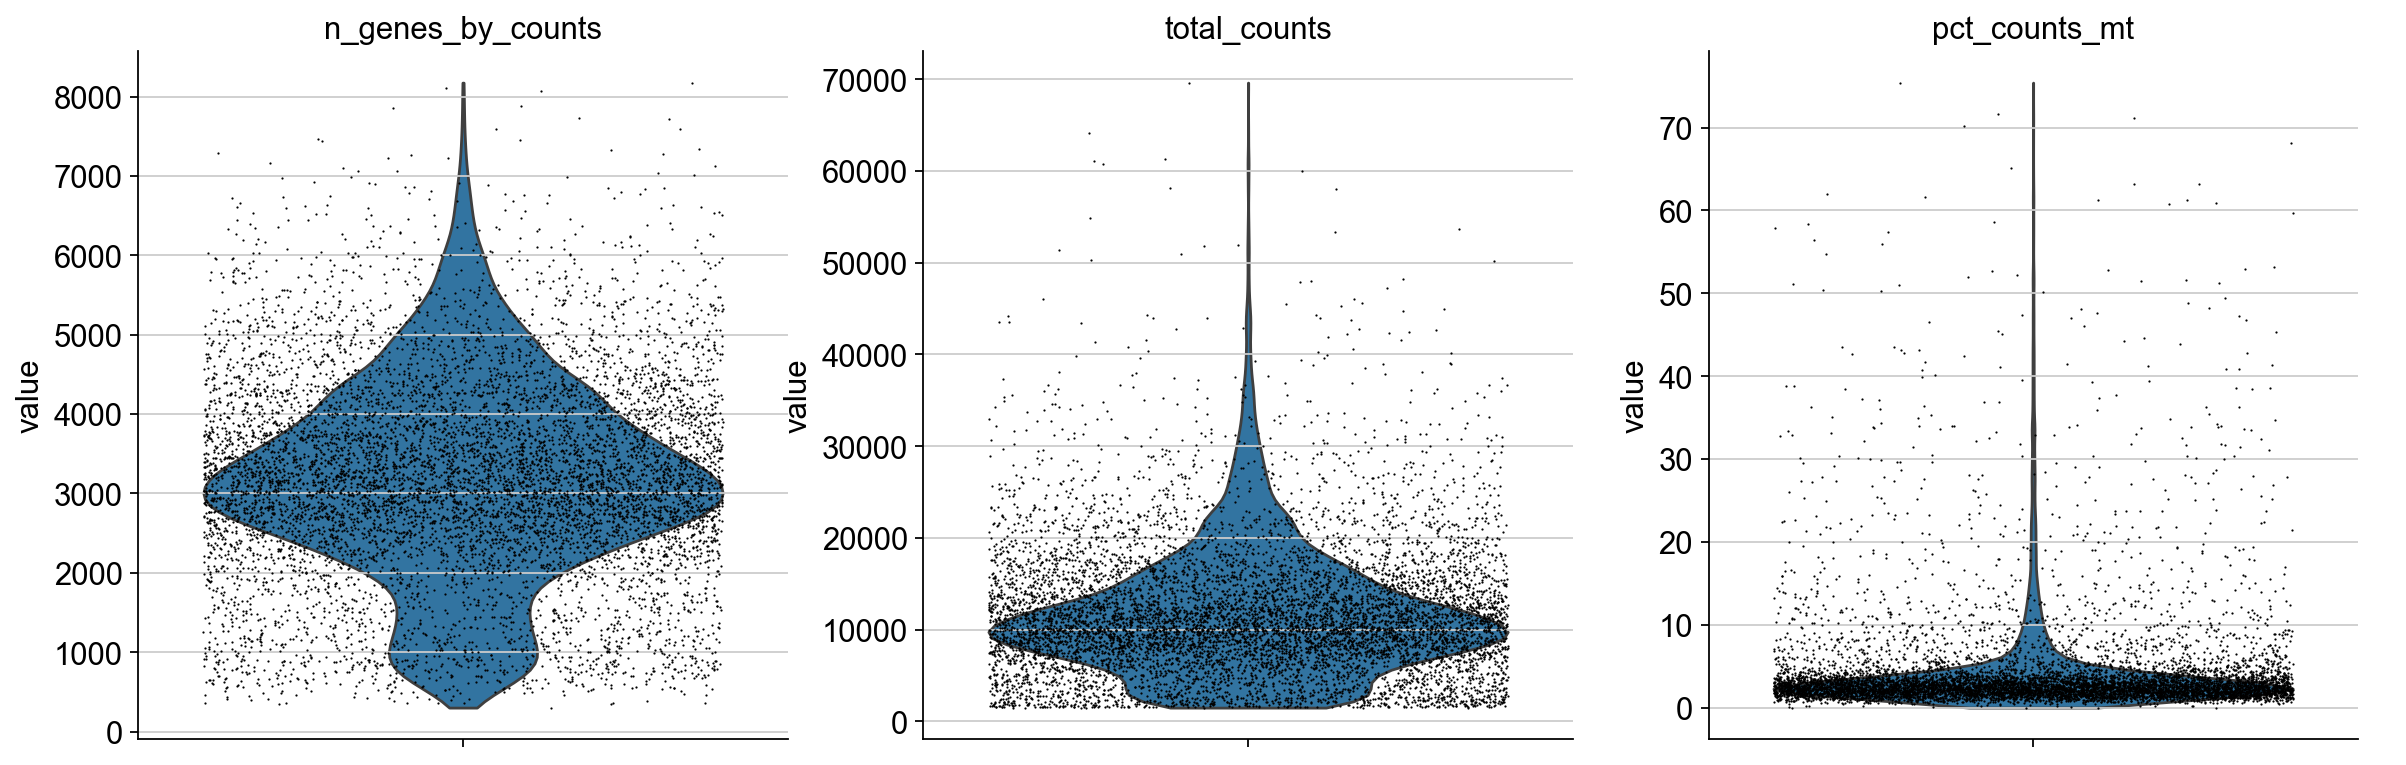

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([1.000e+00, 2.000e+00, 2.000e+00, 7.000e+00, 3.000e+01, 2.130e+02,
        2.468e+03, 4.557e+03, 1.128e+03, 9.400e+01]),
 array([0.68971334, 0.71411837, 0.73852339, 0.76292842, 0.78733344,
        0.81173846, 0.83614349, 0.86054851, 0.88495354, 0.90935856,
        0.93376359]),
 <BarContainer object of 10 artists>)

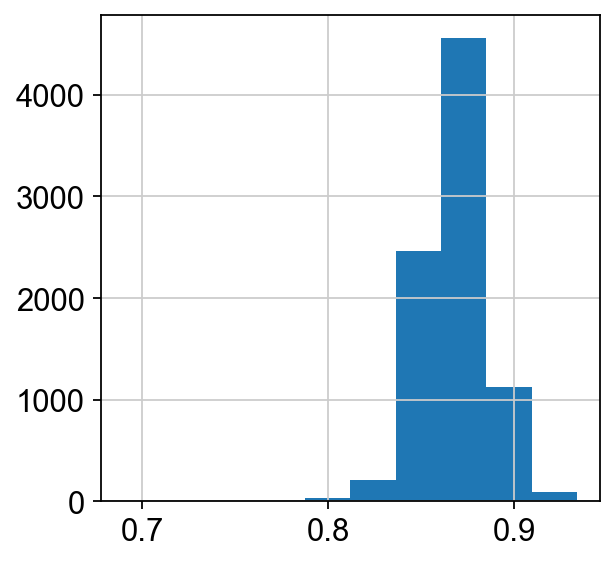

In [14]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

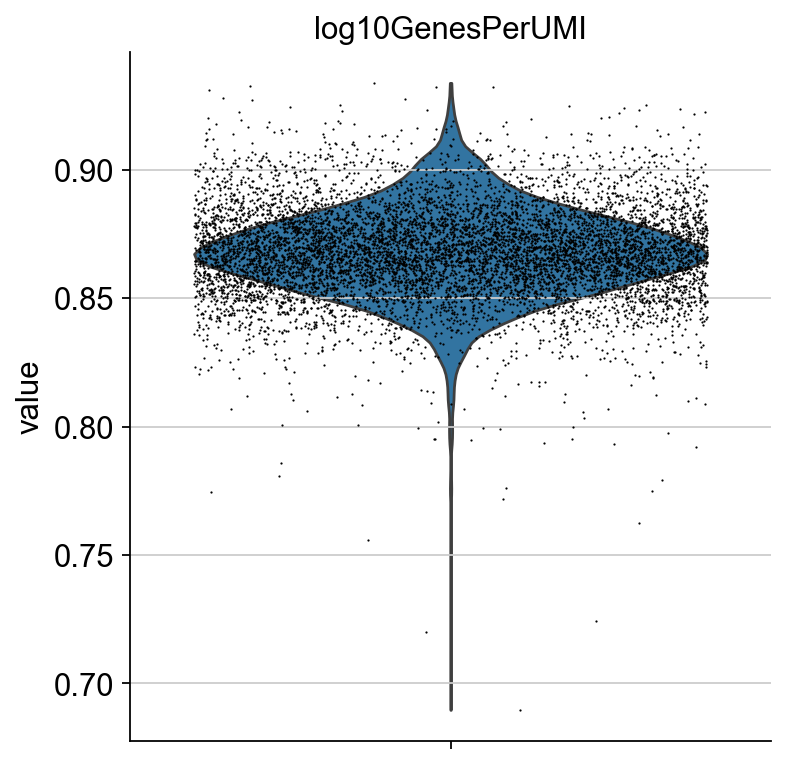

In [15]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)

In [16]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [17]:
adata = adata[adata.obs.pct_counts_mt <= 15, :]

## Run Demultiplexing

In [18]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [19]:
hashadata.var_names

Index(['BF1596_B0301', 'BD1976_B0302', 'BD1959_B0303', 'BF1595_B0304',
       'BF1449_B0305', 'BF1106_B0311', 'BF1588_B0312', 'BD1971_B0313',
       'BB1053_B0314', 'BD1446_B0315'],
      dtype='object')

In [20]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [21]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
#hashDisc

In [22]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
#hashIDs

BF1596_B0301
5.0
BD1976_B0302
3106.0
BD1959_B0303
3306.0
BF1595_B0304
28.0
BF1449_B0305
1043.0
BF1106_B0311
1334.0
BF1588_B0312
1.0
BD1971_B0313
18.0
BB1053_B0314
560.0
BD1446_B0315
7.0


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True  True ...  True False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

In [23]:
from matplotlib import pyplot as plt

In [24]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = (3,4)

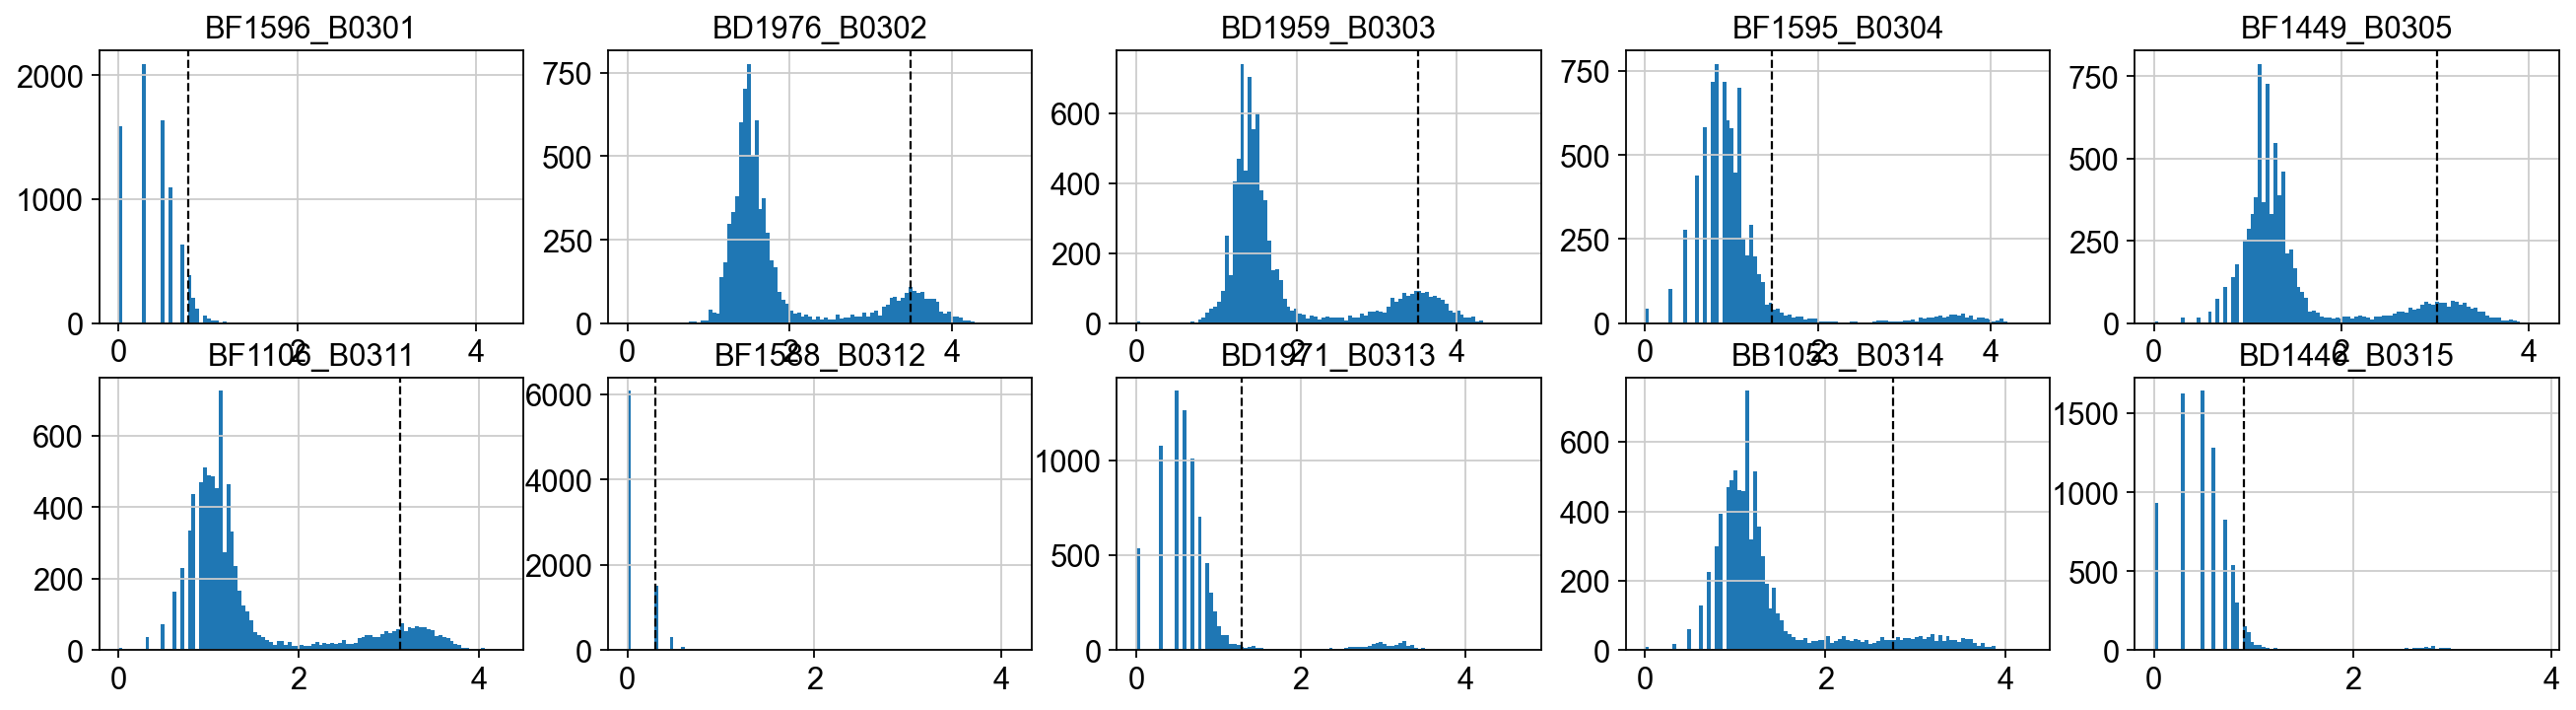

In [25]:
fig, axs = plt.subplots(2,5, figsize =(20, 5))

for i, hashName in enumerate(hashadata.var_names):
    hashCounts2 = np.log10(hashCounts[hashName]+1)
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].hist(hashCounts2, bins = 100)
    axs[i//5,i%5].axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)

#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

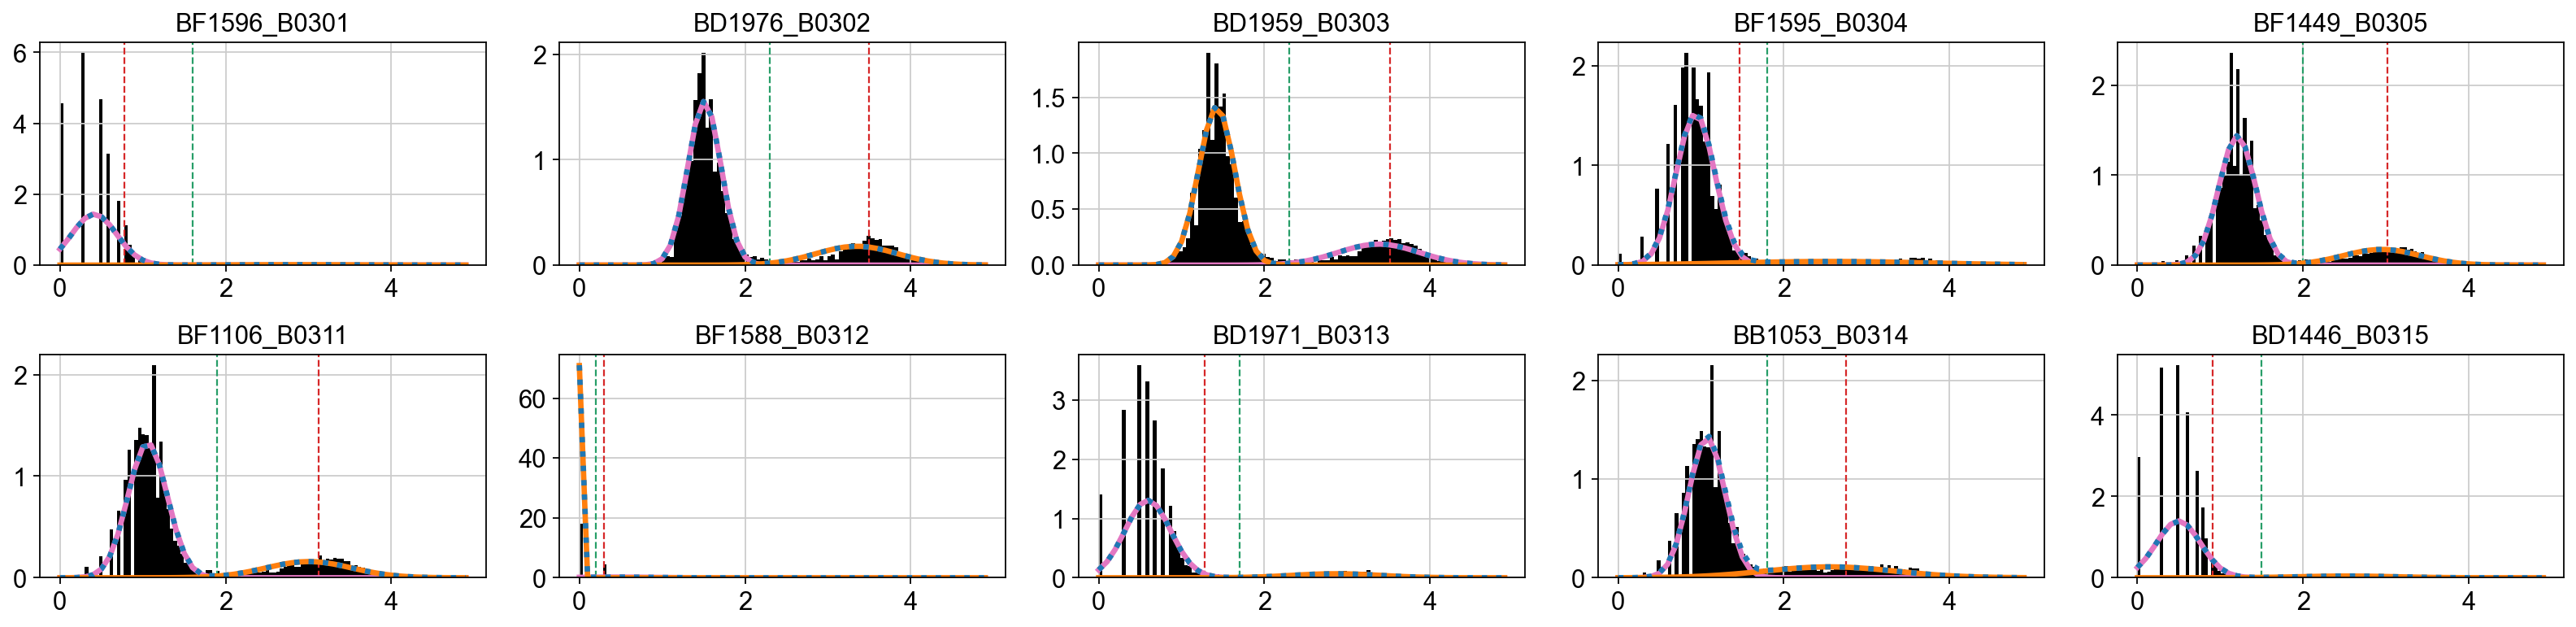

In [26]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    x_axis = np.arange(0, 5, 0.1)
    y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
    y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]    
    if mean[0][0] < mean[1][0]:
        hashBoundry = x_axis[np.where(y_axis1 < y_axis0)[0][-1]+2]
    else:
        hashBoundry = x_axis[np.where(y_axis0 < y_axis1)[0][-1]+2]
    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_axis0, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_axis1, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_axis0+y_axis1, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [27]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

BF1596_B0301
1.6
BD1976_B0302
2.3000000000000003
BD1959_B0303
2.3000000000000003
BF1595_B0304
1.8
BF1449_B0305
2.0
BF1106_B0311
1.9000000000000001
BF1588_B0312
0.2
BD1971_B0313
1.7000000000000002
BB1053_B0314
1.8
BD1446_B0315
1.5


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/416796475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/416796475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True  True ...  True False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/416796475.py:6: FutureWarning: Setting an item of incompati

In [28]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [29]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
doublet         3160
BD1959_B0303     879
BD1976_B0302     805
BF1449_B0305     783
BF1106_B0311     754
BB1053_B0314     684
BD1971_B0313     303
BF1595_B0304     238
negative         183
BD1446_B0315     172
BF1588_B0312      86
BF1596_B0301      64
Name: count, dtype: int64

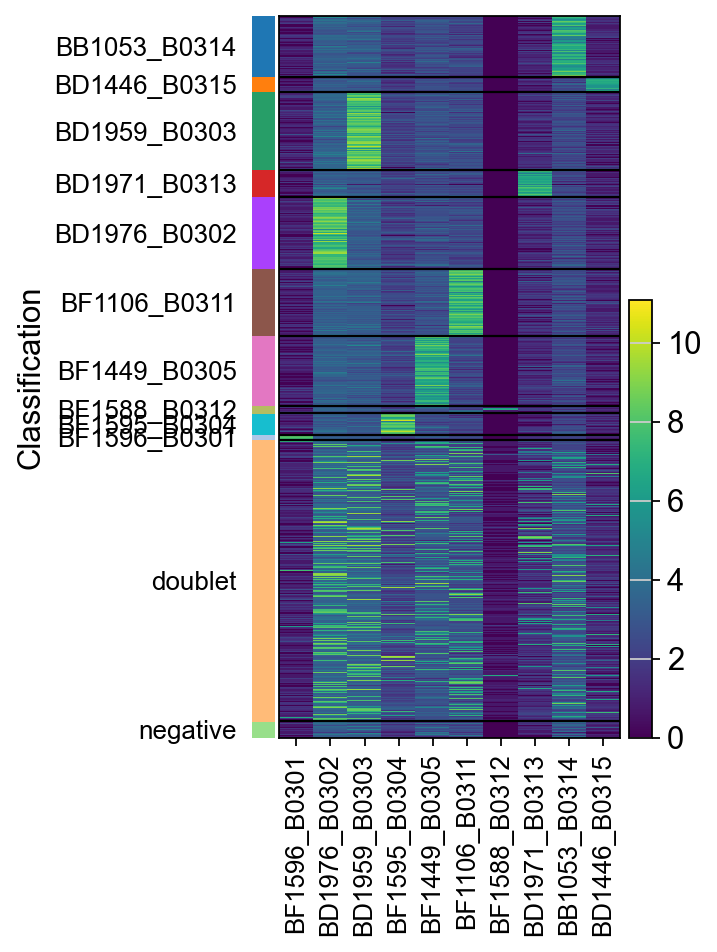

In [30]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set highly variable genes before moving all mean to 0

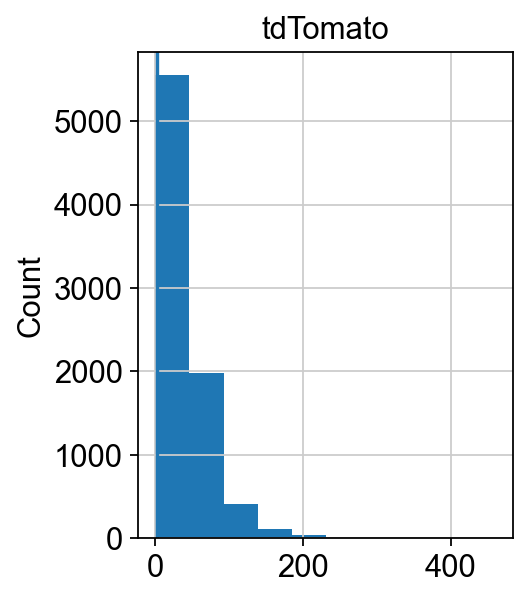

In [31]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['tdTomato'])].toarray())
plt.ylabel("Count")
plt.title("tdTomato")
plt.axvline(x=2)
plt.show()

In [32]:
adata.obs['tdTomato_count'] = adata.X[:,adata.var.index.isin(['tdTomato'])].toarray()

## Filter doublets and negative cells

In [33]:
adata.obs.Classification.value_counts()

Classification
doublet         3160
BD1959_B0303     879
BD1976_B0302     805
BF1449_B0305     783
BF1106_B0311     754
BB1053_B0314     684
BD1971_B0313     303
BF1595_B0304     238
negative         183
BD1446_B0315     172
BF1588_B0312      86
BF1596_B0301      64
Name: count, dtype: int64

In [34]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [35]:
adata.obs.Classification.value_counts()

Classification
BD1959_B0303    879
BD1976_B0302    805
BF1449_B0305    783
BF1106_B0311    754
BB1053_B0314    684
BD1971_B0313    303
BF1595_B0304    238
BD1446_B0315    172
BF1588_B0312     86
BF1596_B0301     64
Name: count, dtype: int64

## Basic processing

In [36]:
adata.layers['counts']=adata.X.copy()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/1857676282.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts']=adata.X.copy()


In [37]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [38]:
sc.pp.log1p(adata)

In [39]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


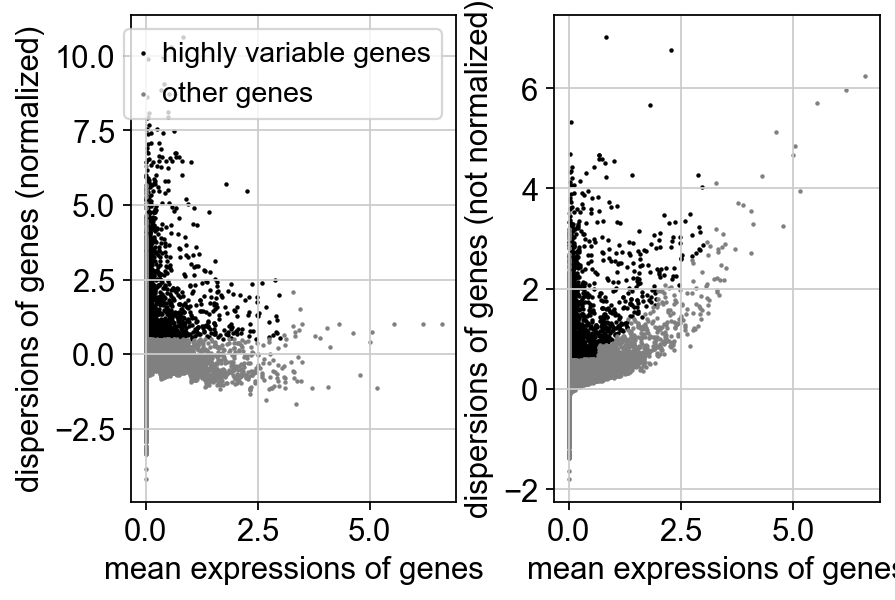

In [40]:
sc.pl.highly_variable_genes(adata)

In [41]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['tdTomato'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/3831354682.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['tdTomato'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/38

In [42]:
adata.write('write/allmice-KPT2.h5ad', compression='gzip')

In [43]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## Principal component analysis

In [44]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    on highly variable genes
    with n_comps=150
    finished (0:00:01)


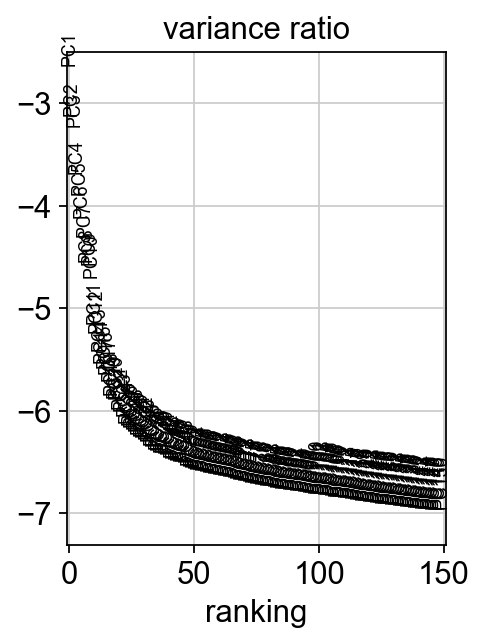

In [45]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

Save the result.

In [46]:
adata.write(results_file, compression='gzip')

## Computing the neighborhood graph

In [47]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

In [48]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


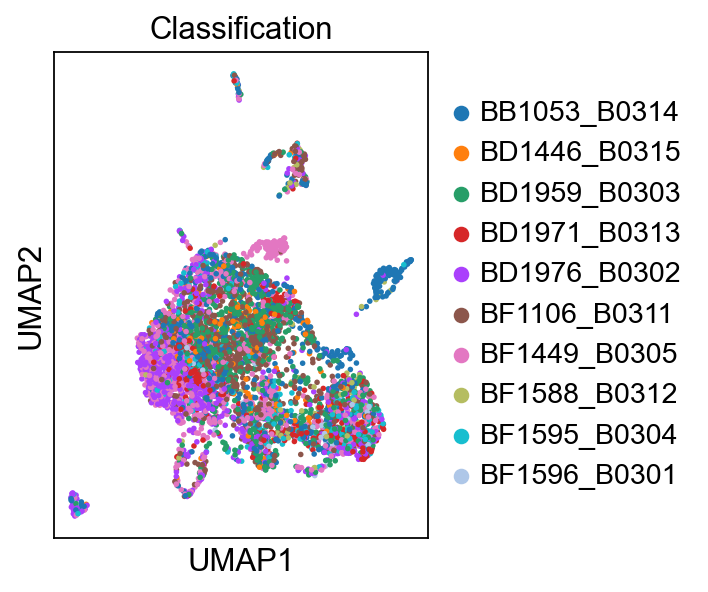

In [49]:
sc.pl.umap(adata, color=['Classification'])

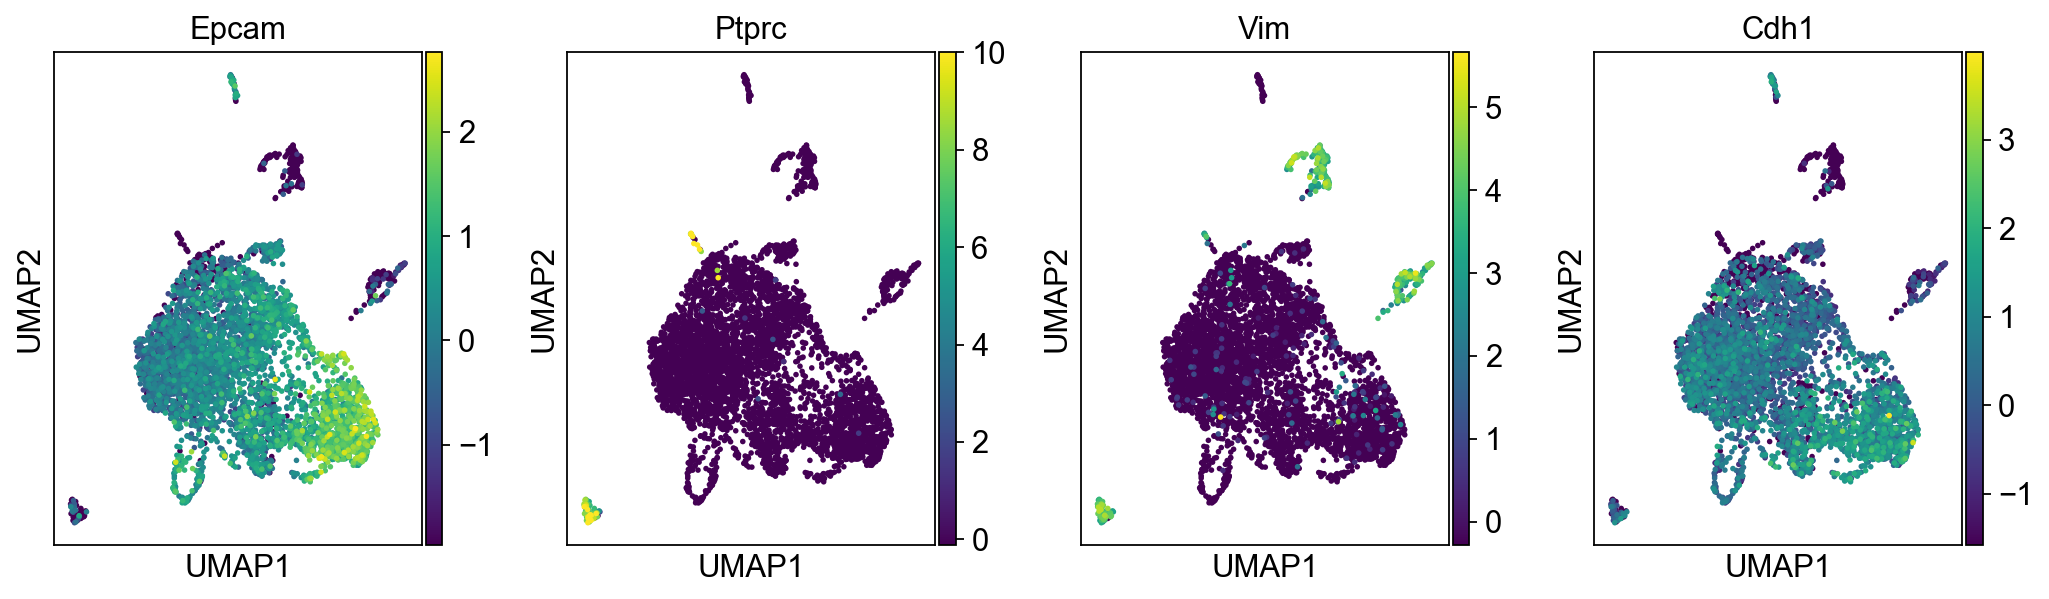

In [50]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

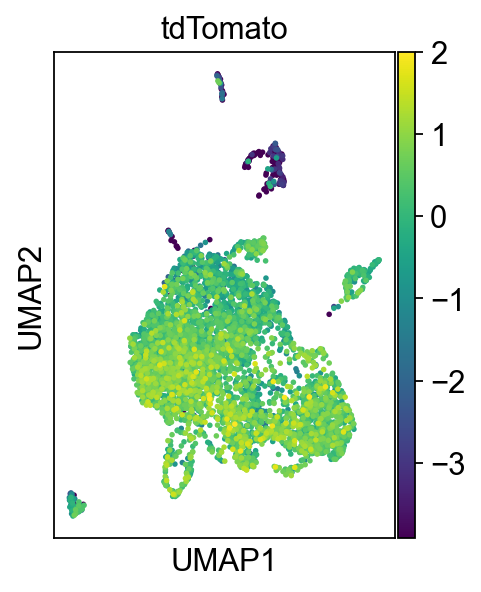

In [51]:
sc.pl.umap(adata, color=['tdTomato',], vmax=2)

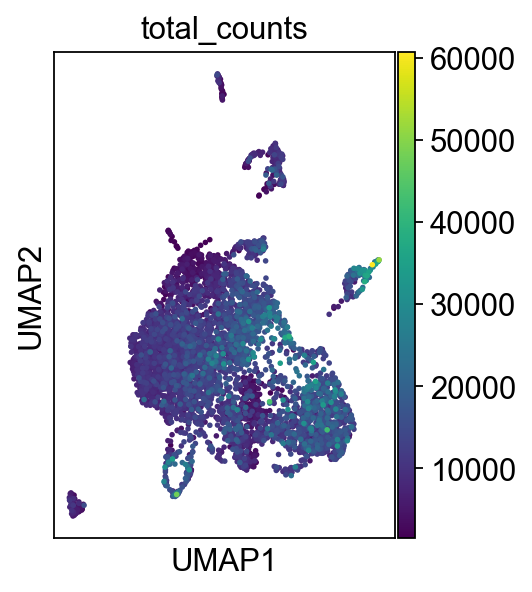

In [52]:
sc.pl.umap(adata, color=['total_counts'])

## Define scoring Functions

In [53]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [54]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=500,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [55]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1687 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1291 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1594 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1291 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1689 total control genes are used. (0:00:00)
computing score 'Cluster 6'
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    1891 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', score of gene set (adata.obs).
    1898 total control genes are u

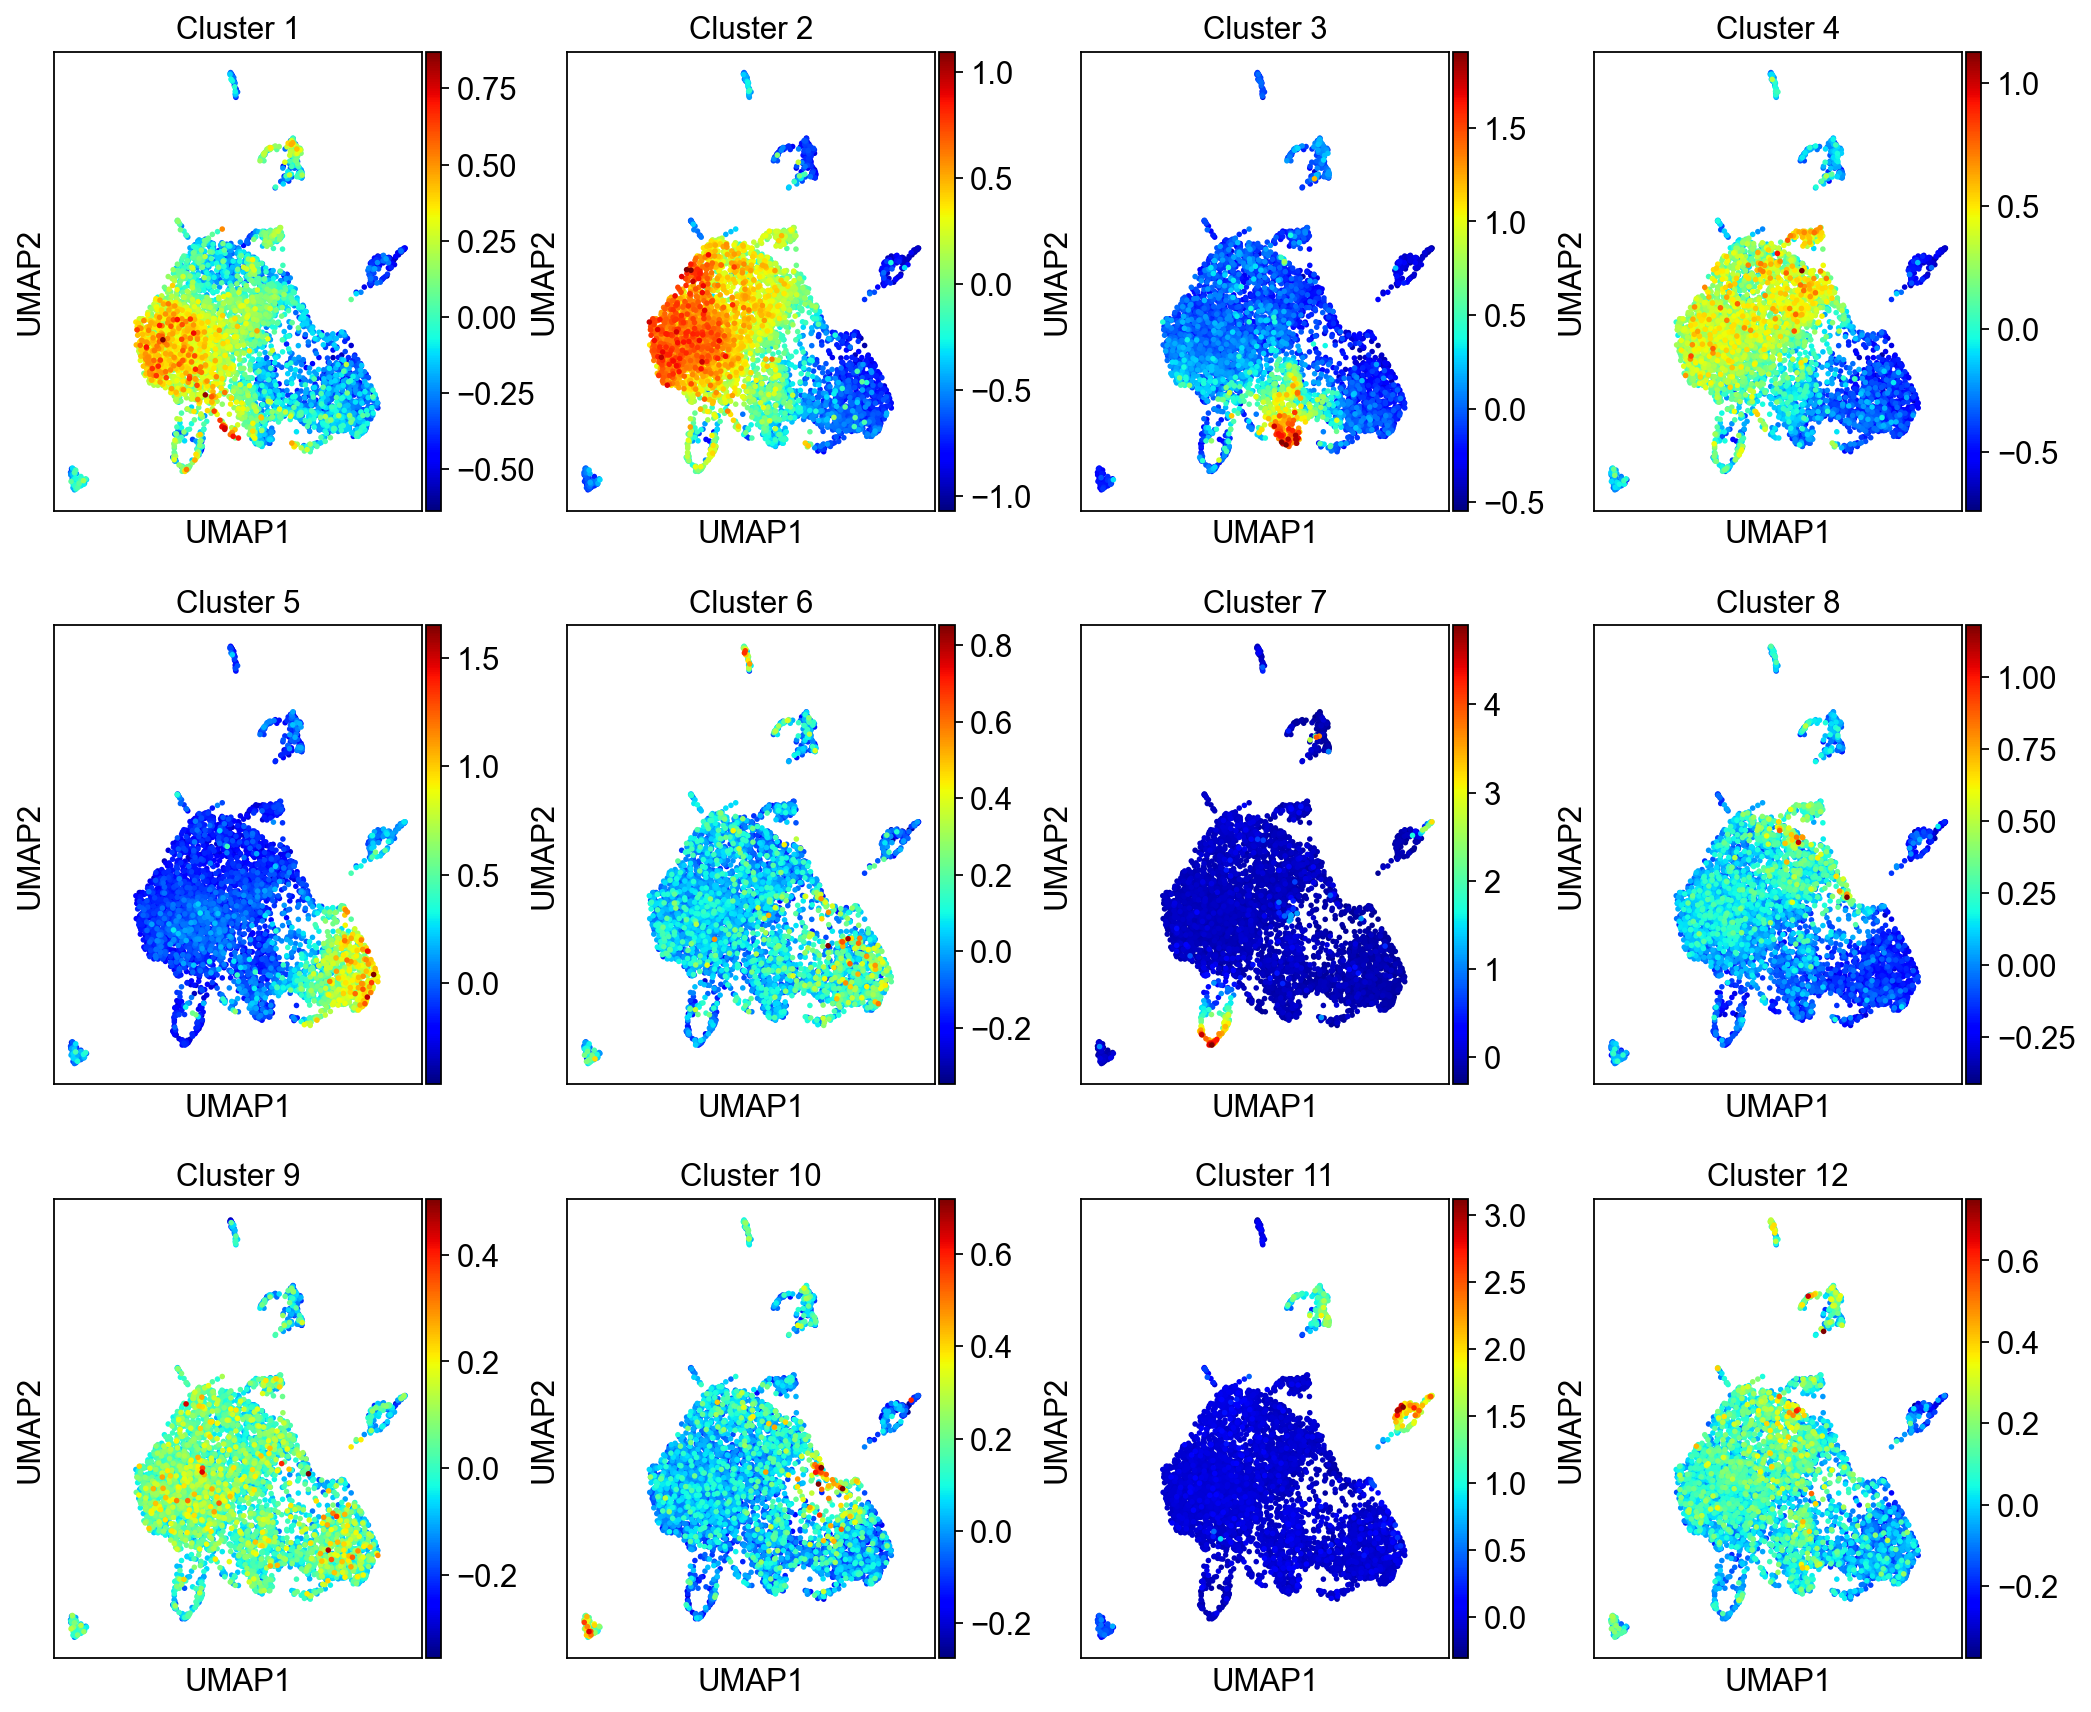

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will b

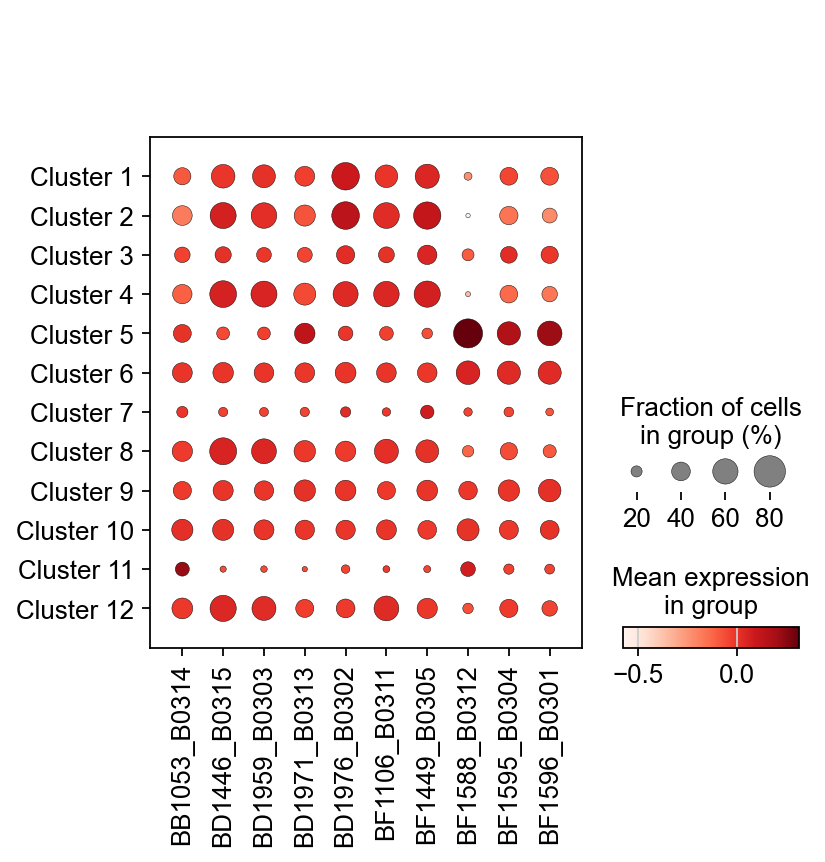

In [56]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [57]:
sc.tl.leiden(adata, resolution=0.2)
#sc.tl.leiden(adata, resolution=0.25)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


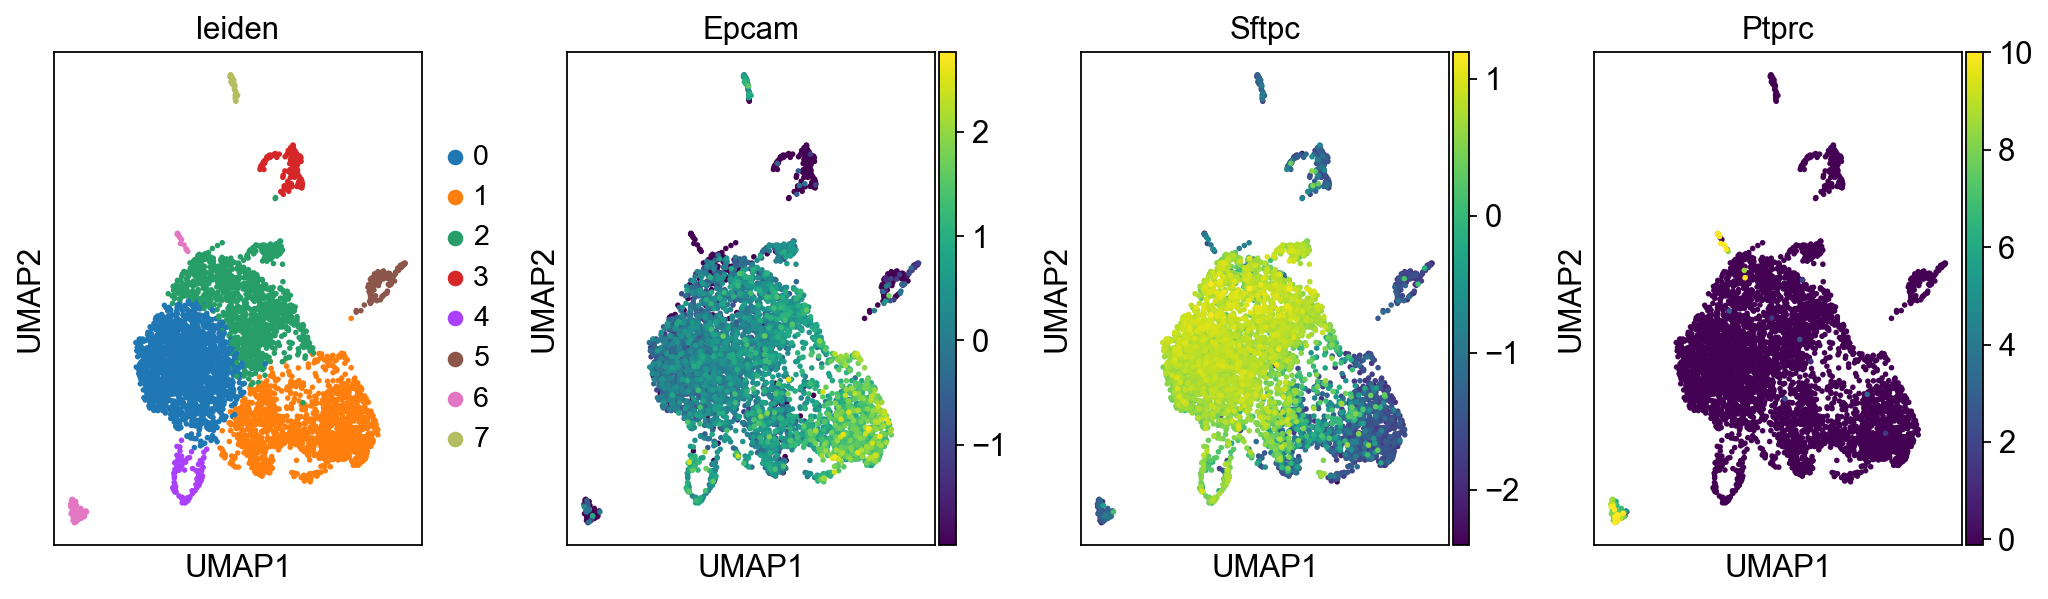

(None,)

In [58]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

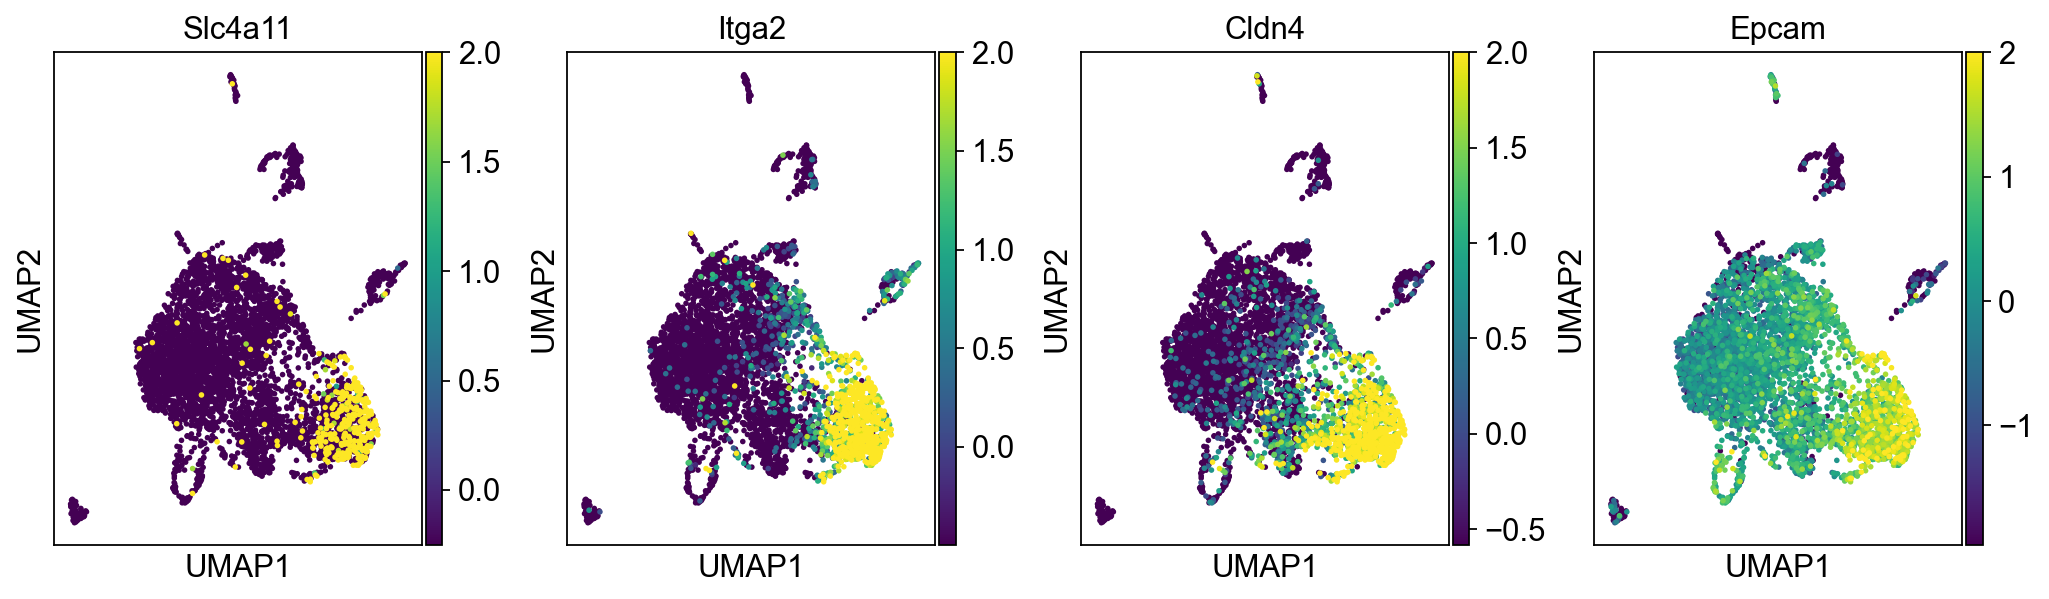

In [59]:
sc.pl.umap(adata, color=['Slc4a11', 'Itga2', 'Cldn4','Epcam'], vmax=2) #'Tigit', 

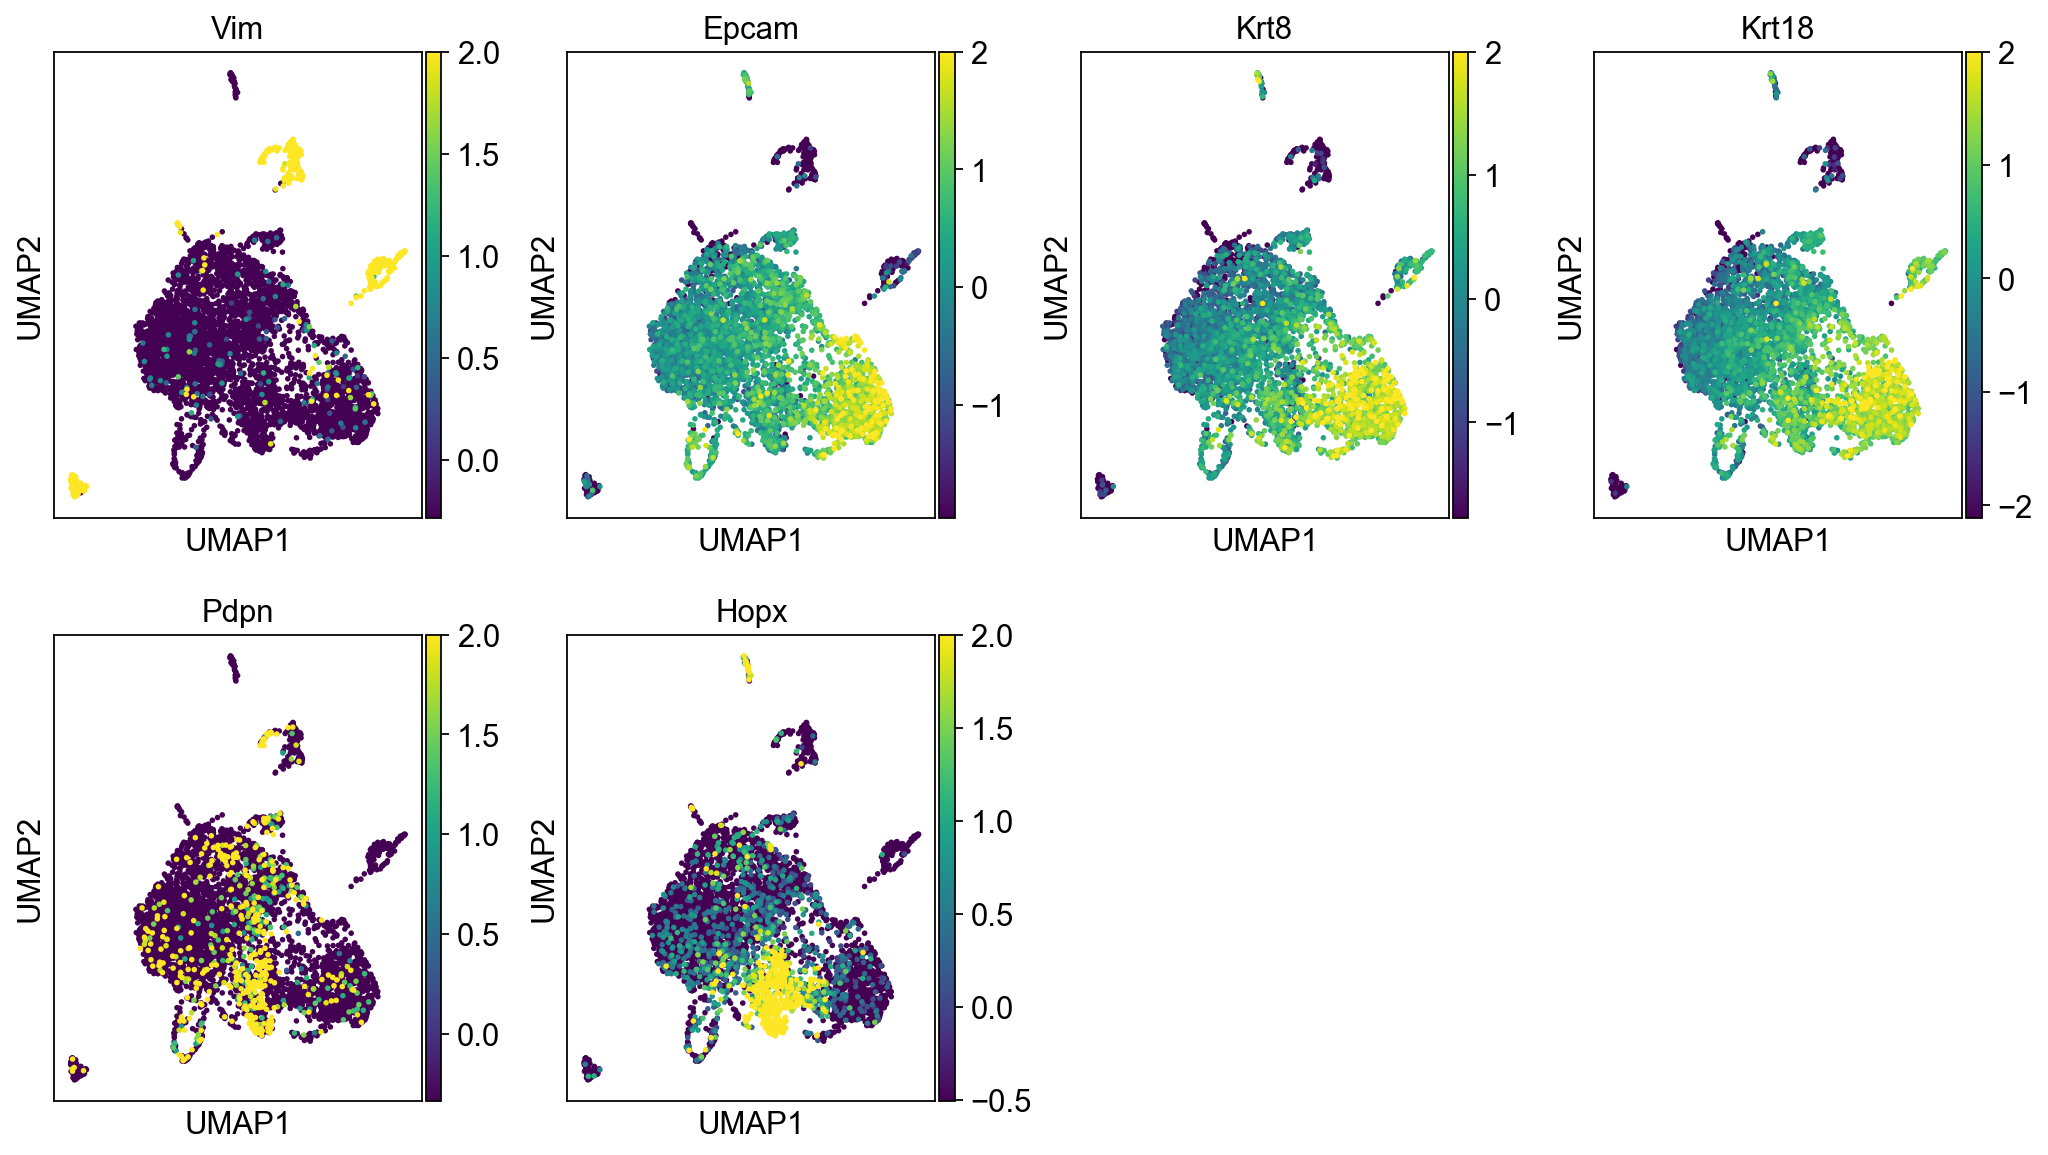

In [60]:
sc.pl.umap(adata, color=['Vim', 'Epcam', 'Krt8', 'Krt18', 'Pdpn', 'Hopx'], vmax=2) #'Pecam1',

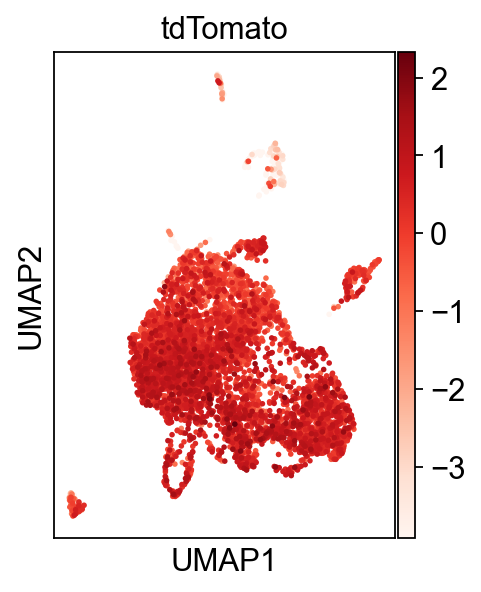

In [61]:
sc.pl.umap(adata, color=['tdTomato'], cmap='Reds')

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


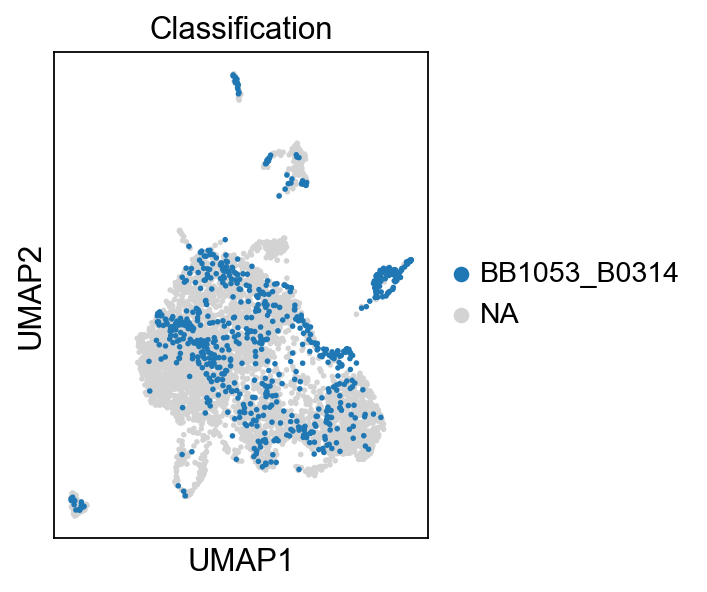

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


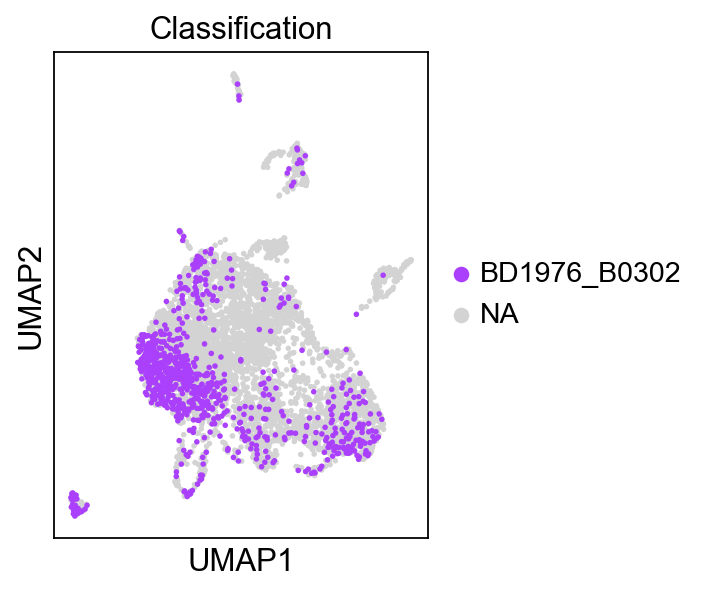

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


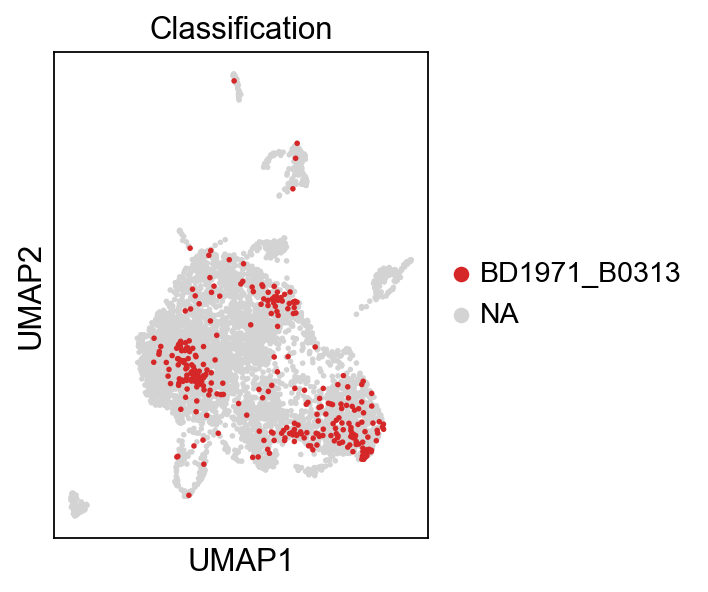

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


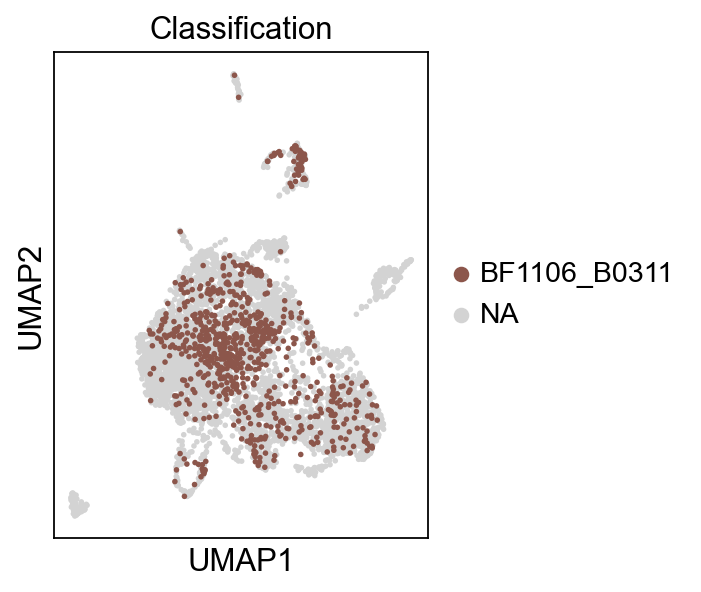

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


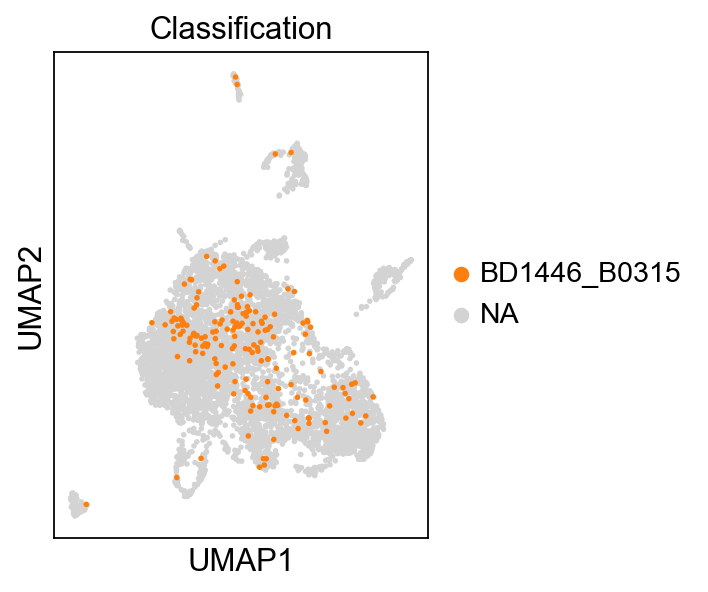

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


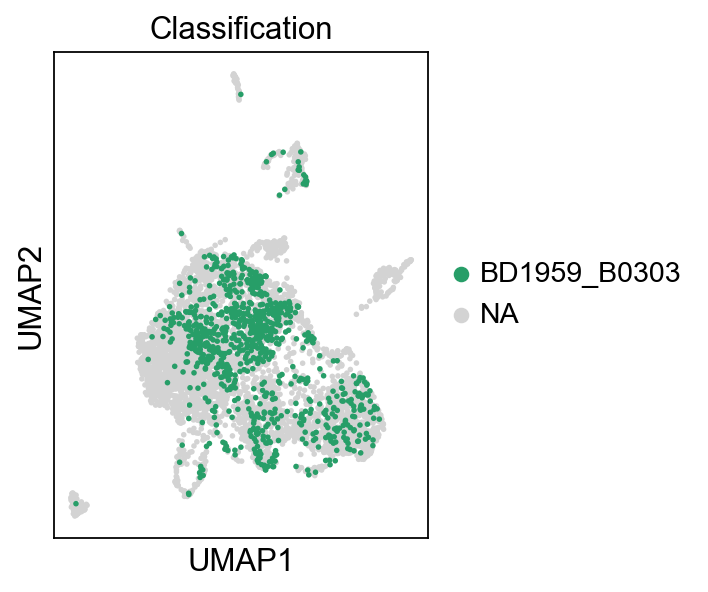

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


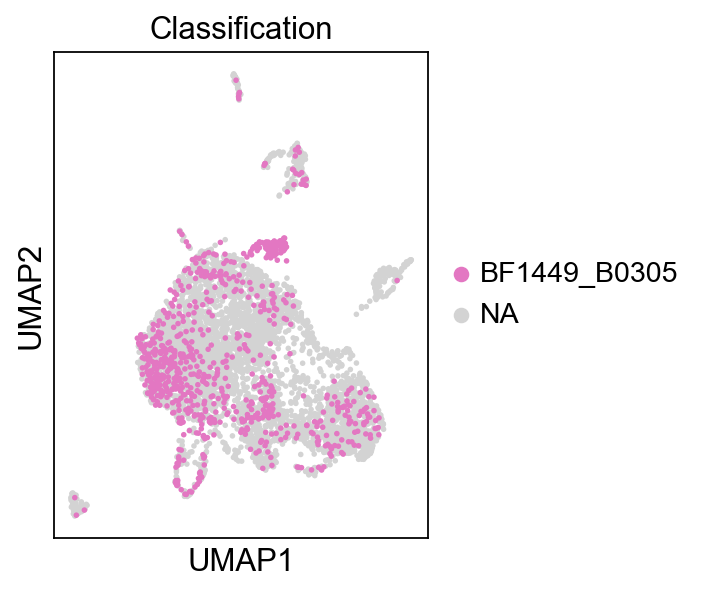

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


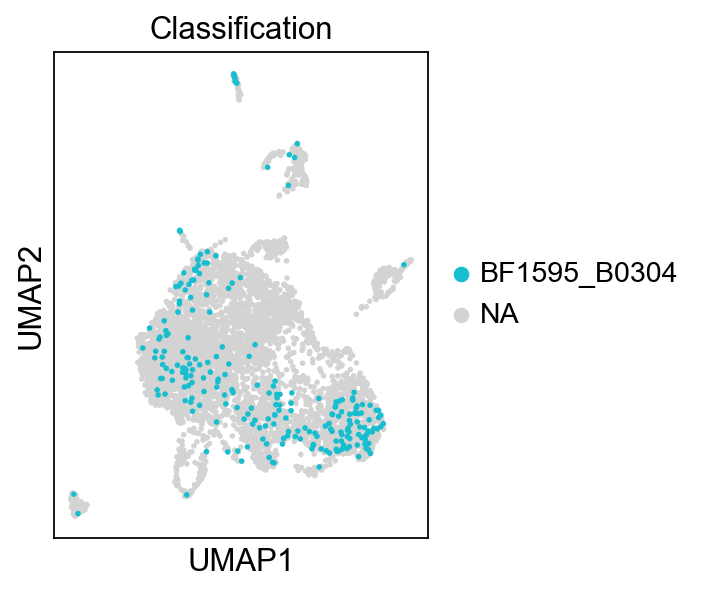

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


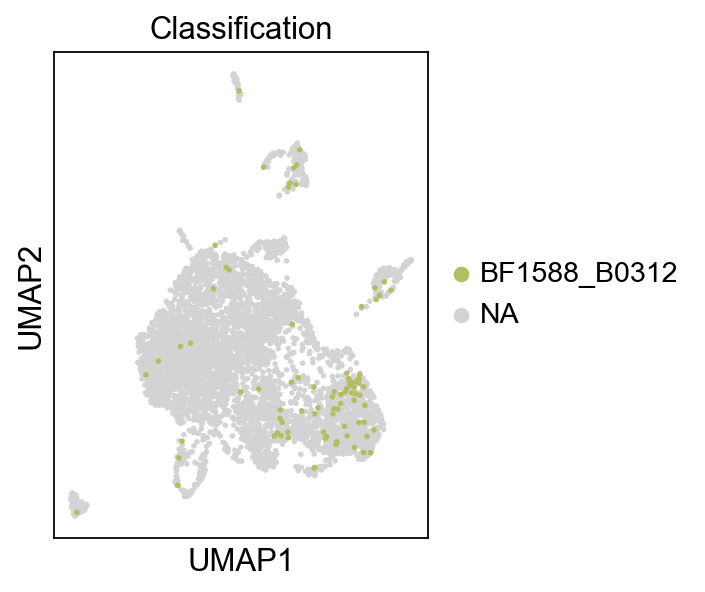

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


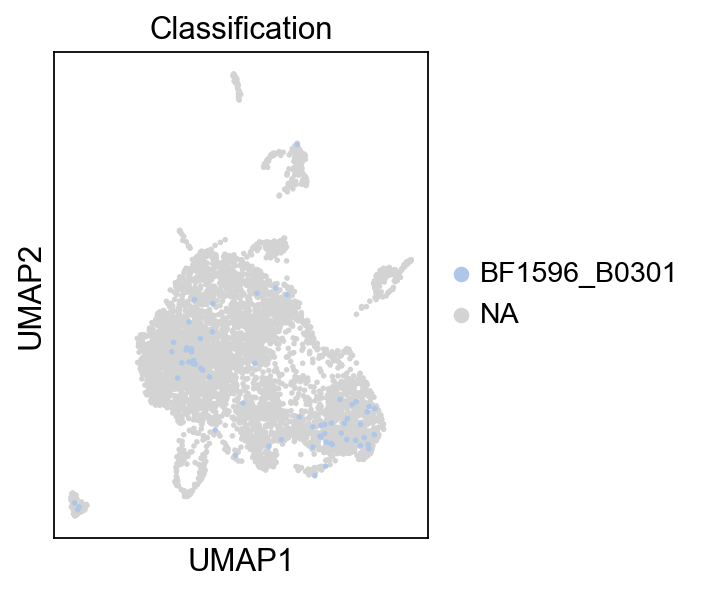

In [62]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

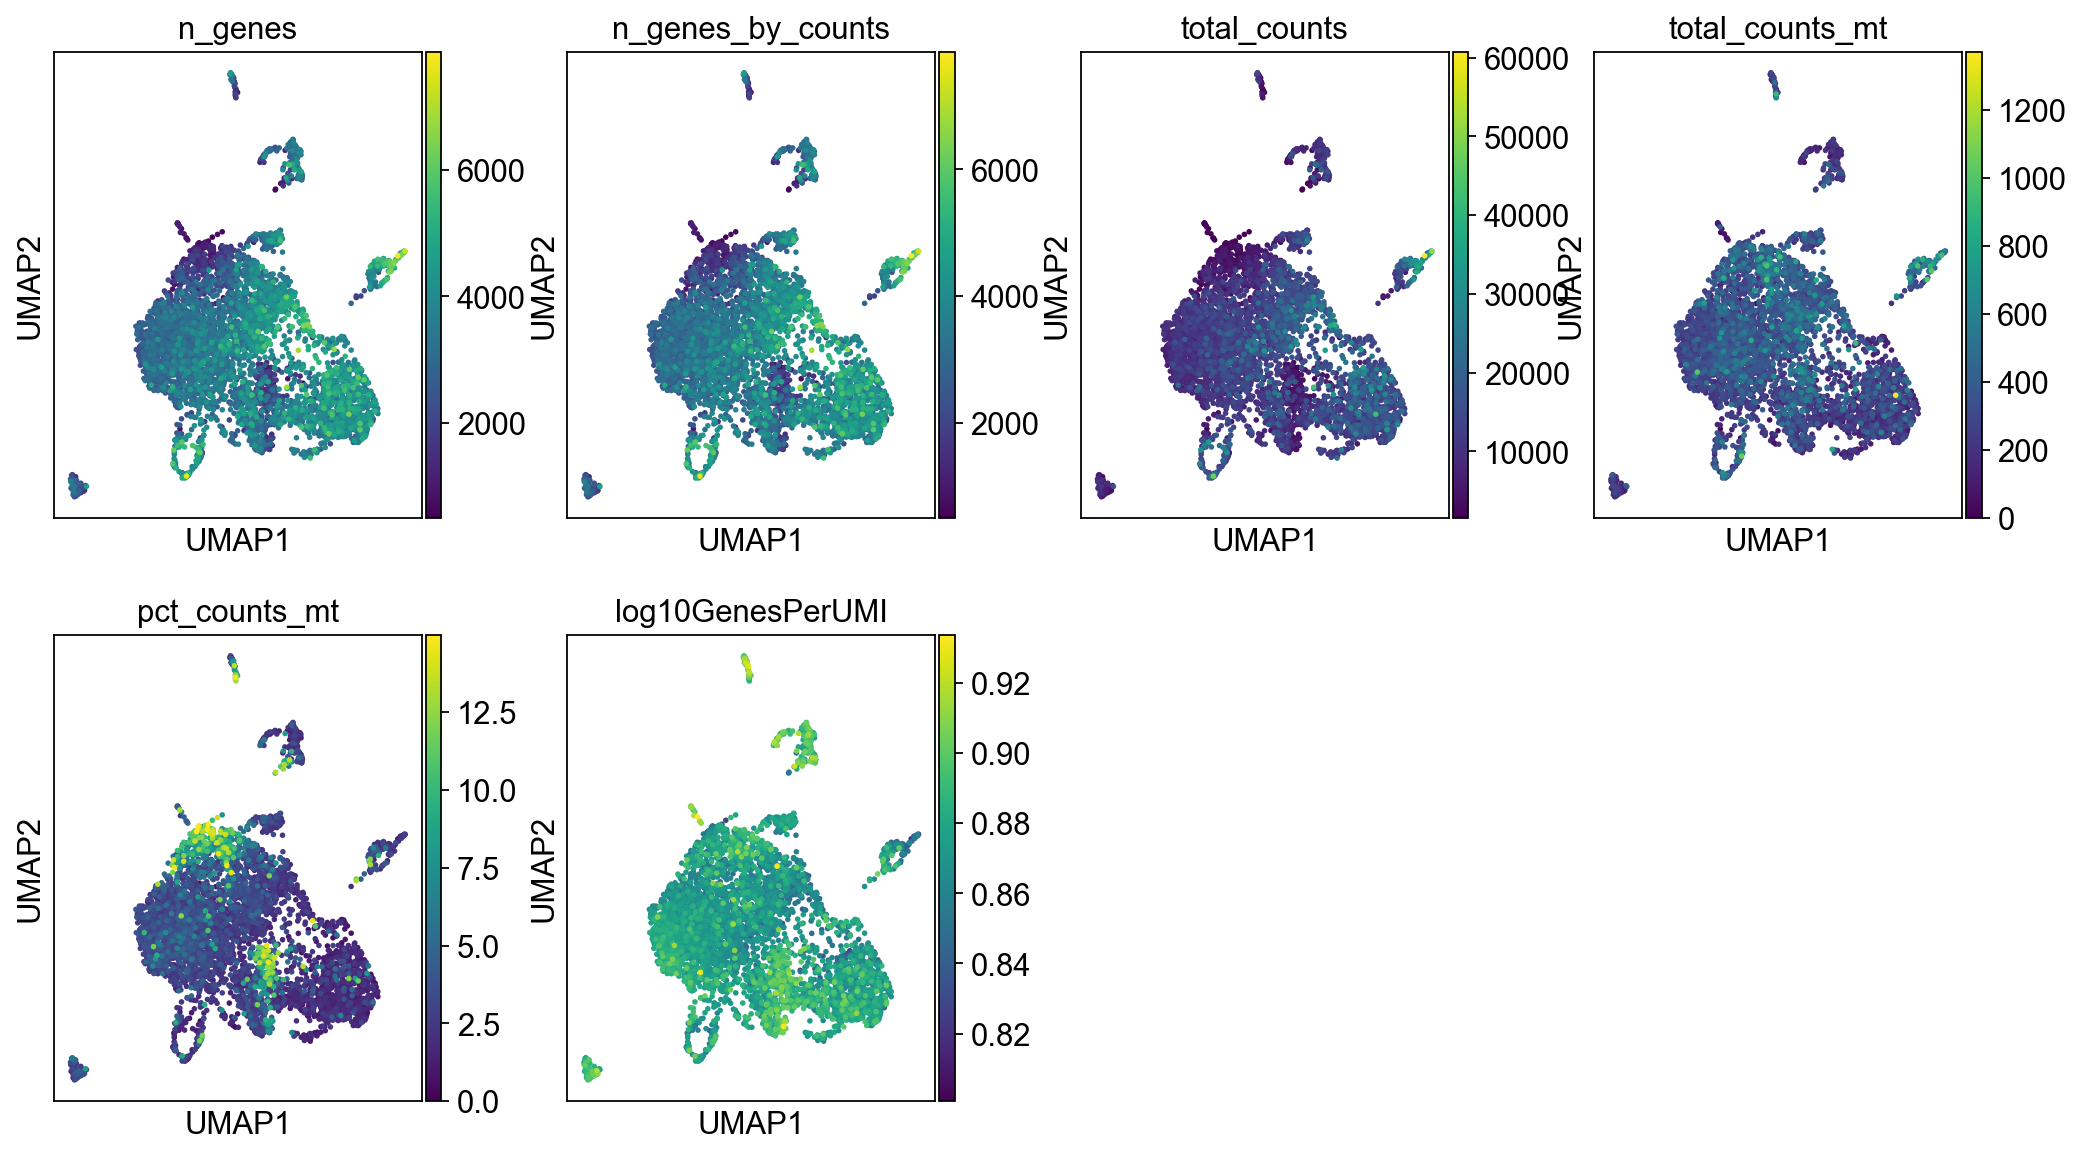

In [63]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


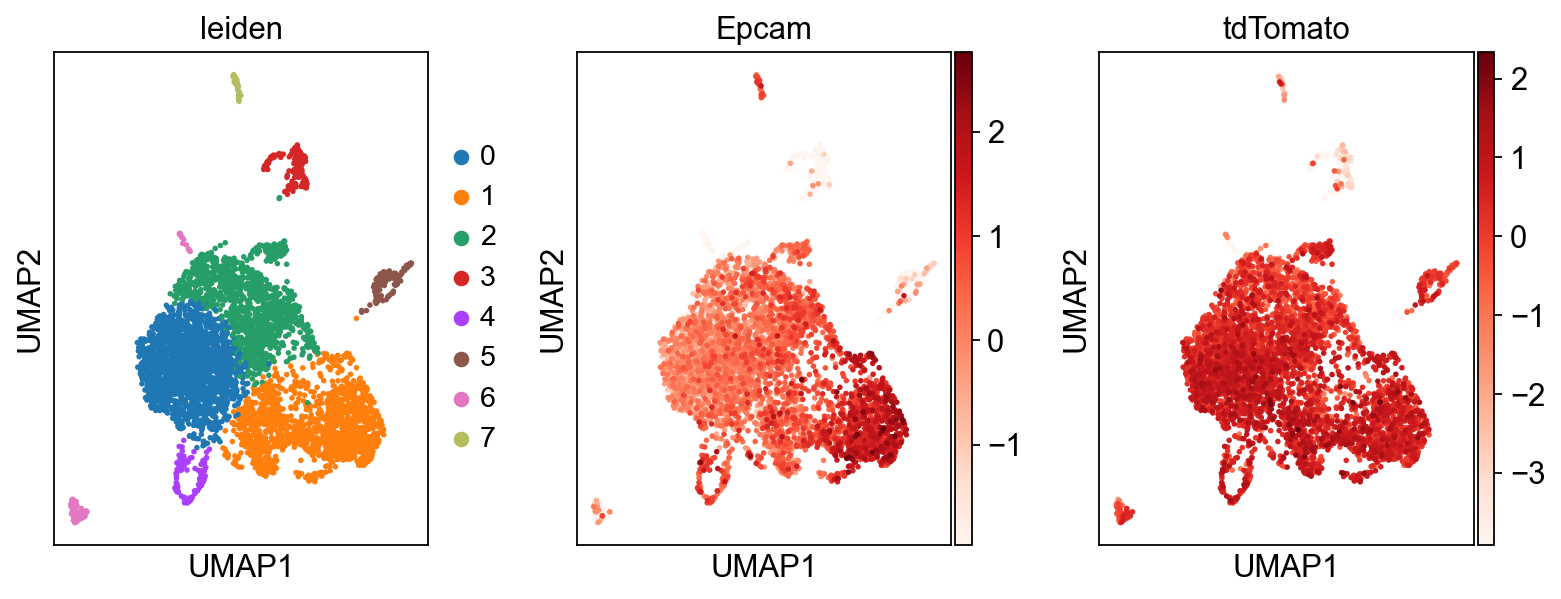

In [64]:
sc.pl.umap(adata, color=['leiden','Epcam','tdTomato'],cmap="Reds")

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


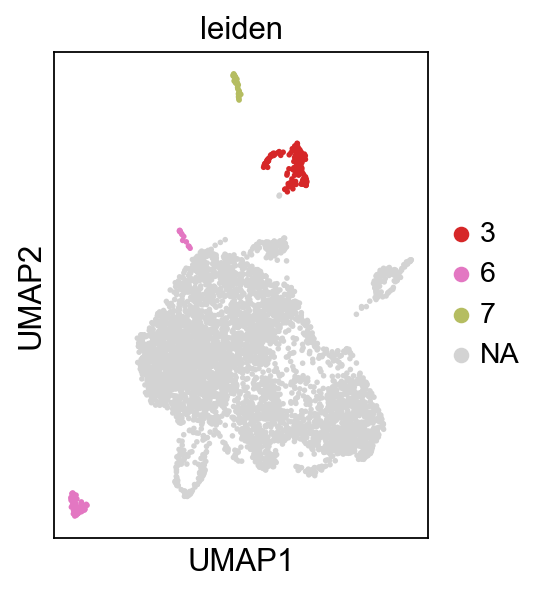

In [65]:
sc.pl.umap(adata, color=['leiden'], groups=['3','6','7'])

## Select Tumor Cells

In [66]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/allmice-KPT2.h5ad')
adata = adata2[~adata.obs['leiden'].isin(['3','6','7']),:] # keep tumor cells
del adata2

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [67]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [68]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [69]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['tdTomato'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/3831354682.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['tdTomato'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_55858/38

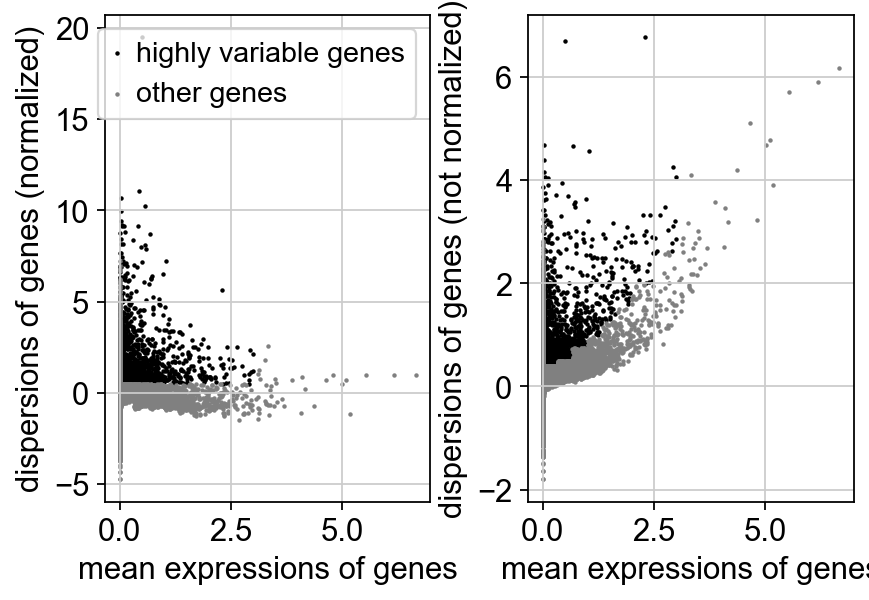

In [70]:
sc.pl.highly_variable_genes(adata)

In [71]:
adata.write('write/allmice-tumor-KPT2.h5ad', compression='gzip')